# Проект AB тестирования гипотез по увеличению выручки интернет магазина

**Описание проекта**

**Контекст**

Отделом маркетинга заказчика были подготовлены гипотезы для увеличения выручки.
Задача: приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

**Описание данных**

**Данные для первой части**

Файл /datasets/hypothesis.csv. Скачать датасет

-	Hypothesis — краткое описание гипотезы;
-	Reach — охват пользователей по 10-балльной шкале;
-	Impact — влияние на пользователей по 10-балльной шкале;
-	Confidence — уверенность в гипотезе по 10-балльной шкале;
-	Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**

Файл /datasets/orders.csv. Скачать датасет
-	transactionId — идентификатор заказа;
-	visitorId — идентификатор пользователя, совершившего заказ;
-	date — дата, когда был совершён заказ;
-	revenue — выручка заказа;
-	group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv. Скачать датасет
-	date — дата;
-	group — группа A/B-теста;
-	visitors — количество пользователей в указанную дату в указанной группе A/B-теста





## Подготовка данных к анализу 

Загрузка библиотек:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from scipy import stats as st
from datetime import datetime, timedelta
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format
import scipy.stats as stats
import datetime as dt

Загрузка датафремов и анализ данных

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
    
except:
    hypothesis = pd.read_csv('hypothesis.csv')
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')

Просмотр содержания датафремов:

In [3]:
hypothesis.info()

display(hypothesis.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
orders.info()
print(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
   transactionId   visitorId        date  revenue group
0     3667963787  3312258926  2019-08-15     1650     B
1     2804400009  3642806036  2019-08-15      730     B
2     2961555356  4069496402  2019-08-15      400     A
3     3797467345  1196621759  2019-08-15     9759     B
4     2282983706  2322279887  2019-08-15     2308     B


In [5]:
visitors.info()
print(visitors.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
         date group  visitors
0  2019-08-01     A       719
1  2019-08-02     A       619
2  2019-08-03     A       507
3  2019-08-04     A       717
4  2019-08-05     A       756


Проверка на пропуски:

In [6]:
display(hypothesis.isna().sum())
display(orders.isna().sum())
display(visitors.isna().sum())

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

date        0
group       0
visitors    0
dtype: int64

Проверка на наличие дубликатов:

In [7]:
hypothesis.duplicated().sum()

0

In [8]:
orders.duplicated().sum()

0

In [9]:
visitors.duplicated().sum()

0

В датафрейме hypothesis приведем названия колонок к нижнему регистру:

In [10]:
hypothesis.columns = map(str.lower, hypothesis.columns)

Переведем информацию о датах из типа object в тип datetime:

In [11]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

**В предоставленных данных нет дубликатов и пропусков. В процессе подготовки данных в датафрейме hypothesis названия колонок приведены к нижнему регистру, в остальных двух датафреймах изменен тип данных колонки date на datetime. Данные готовы к анализу**

Посчитаем количество уникальных пользователей и кол-во групп, в которые они объеденены:

In [13]:
orders['group'].unique() 

array(['B', 'A'], dtype=object)

In [14]:
visitor_unique = orders['visitorId'].value_counts()
print(visitor_unique)

4256040402    11
2458001652    11
2378935119     9
2038680547     8
199603092      5
              ..
2524310328     1
2210805728     1
2274825520     1
1831227158     1
2108080724     1
Name: visitorId, Length: 1031, dtype: int64


**Итак, 1031 уникальный пользователь сгруппированы в 2 группы**

In [15]:
ordersA = orders.loc[orders['group'] == "A"]
display(ordersA['visitorId'].value_counts())

4256040402    7
2038680547    5
2458001652    5
2378935119    4
237748145     4
             ..
1957949546    1
2971471657    1
109615108     1
1917506191    1
573423106     1
Name: visitorId, Length: 503, dtype: int64

In [16]:
ordersB = orders.loc[orders['group'] == "B"]
display(ordersB['visitorId'].value_counts())

2458001652    6
2378935119    5
4256040402    4
3062433592    4
3803269165    4
             ..
1147554328    1
1687240555    1
3741503045    1
4186744110    1
2108080724    1
Name: visitorId, Length: 586, dtype: int64

Проверим повторяющихся пользователей в группах:

In [17]:
ordersA = orders.loc[orders['group'] == "A"]
ordersB = orders.loc[orders['group'] == "B"]
repeated_users = orders.loc[orders['visitorId'].isin(ordersA['visitorId'])& orders['visitorId'].isin(ordersB['visitorId'])]
print(repeated_users)


      transactionId   visitorId       date  revenue group
2        2961555356  4069496402 2019-08-15      400     A
20       2904772834   963407295 2019-08-15      300     B
23       4252514150   351125977 2019-08-15    15185     B
24       1162046357  3234906277 2019-08-15     7555     B
26       2223239646   199603092 2019-08-15     3488     A
...             ...         ...        ...      ...   ...
1182     2682156369  1668030113 2019-08-14     1290     B
1183     1458356232   963407295 2019-08-14     4940     A
1184     1329499668  2949041841 2019-08-14    10380     B
1189     4082620617   393266494 2019-08-14    31550     B
1195     1947021204  1614305549 2019-08-14      100     A

[181 rows x 5 columns]


In [18]:
orders = orders.loc[~orders['visitorId'].isin(repeated_users['visitorId'])]
print(orders)

      transactionId   visitorId       date  revenue group
0        3667963787  3312258926 2019-08-15     1650     B
1        2804400009  3642806036 2019-08-15      730     B
3        3797467345  1196621759 2019-08-15     9759     B
4        2282983706  2322279887 2019-08-15     2308     B
5         182168103   935554773 2019-08-15     2210     B
...             ...         ...        ...      ...   ...
1191     3592955527   608641596 2019-08-14    16490     B
1192     2662137336  3733762160 2019-08-14     6490     B
1193     2203539145   370388673 2019-08-14     3190     A
1194     1807773912   573423106 2019-08-14    10550     A
1196     3936777065  2108080724 2019-08-15   202740     B

[1016 rows x 5 columns]


Расчет показал наличие повторений пользователей как в гр А так и в гр В. Данный факт не должен сильно повлиять на конечные результаты анализа, т.к. датафрейм visitors содержит кумулятивные данные. 


Посмотрим период за который предоставлены данные:

In [19]:
orders['date'].describe()

C:\Users\Mi\AppData\Local\Temp\ipykernel_28552\4197849394.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  orders['date'].describe()


count                    1016
unique                     31
top       2019-08-05 00:00:00
freq                       43
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [20]:
visitors['date'].describe()

C:\Users\Mi\AppData\Local\Temp\ipykernel_28552\511156166.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  visitors['date'].describe()


count                      62
unique                     31
top       2019-08-01 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

**И в датасете orders и в датасете visitors нам доступны данные с 1 по 31 августа 2019 г.**

## Приоритизация гипотез.

###	Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

Просмотр текста гипотез:

In [21]:

pd.set_option('display.max_colwidth', 500)
display(hypothesis.head(10))

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [22]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


###	Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.


In [23]:
hypothesis['RICE'] = hypothesis['impact'] * hypothesis['confidence'] * hypothesis['reach'] / hypothesis['efforts']
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


### 	Анализ изменения приоритизации гипотез при применении RICE вместо ICE. Пояснения.

In [24]:
hypothesis[['hypothesis', 'ICE', 'RICE', 'reach']]

,hypothesis,ICE,RICE,reach
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.00,3
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.00,2
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.00,8
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.00,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.00,3
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.00,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.00,5
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.00,10
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.20,1


In [25]:
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


**Выводы:** 

ICE: на первых трех местах гипотезы с индексами 8, 0 и 7, с достаточно высоким показателем влияния изменений на пользователей (impact) и высокой уровнем уверенности в оценках парметров коэффициента (confidence)

При приоритезации гипотез с помощью фреймворка RICE на первые места по приоретизации выходят гипотезы с индексами 7 (ICE на 3 месте), 2 (ICE на 5 месте) и 0 (ICE на 2 месте). Здесь на первое место по приоретизации выходят гипотезы с высоким параметром охвата пользователей и это гипотезы с индексами 7 и 2. 

Приоритет в дальнейшем тестировании отдается гипотезе с индексом 7 и возможно также необходимо проверить гипотезу 2. 

## Анализ A/B-теста

### Подготовка данных

Создадим массив уникальных пар значений дат и групп теста методом drop_duplicates():

In [26]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

Соберём агрегированные кумулятивные по дням данные о заказах.

In [27]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

Аналогично получим агрегированные кумулятивные по дням данные о посетителях:

In [28]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [29]:

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulativeData.head(10))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
5,2019-08-03,B,54,53,288850,1803
6,2019-08-04,A,77,71,388030,2562
7,2019-08-04,B,68,66,385740,2573
8,2019-08-05,A,99,92,474413,3318
9,2019-08-05,B,89,87,475648,3280


###	График кумулятивной выручки по группам. 

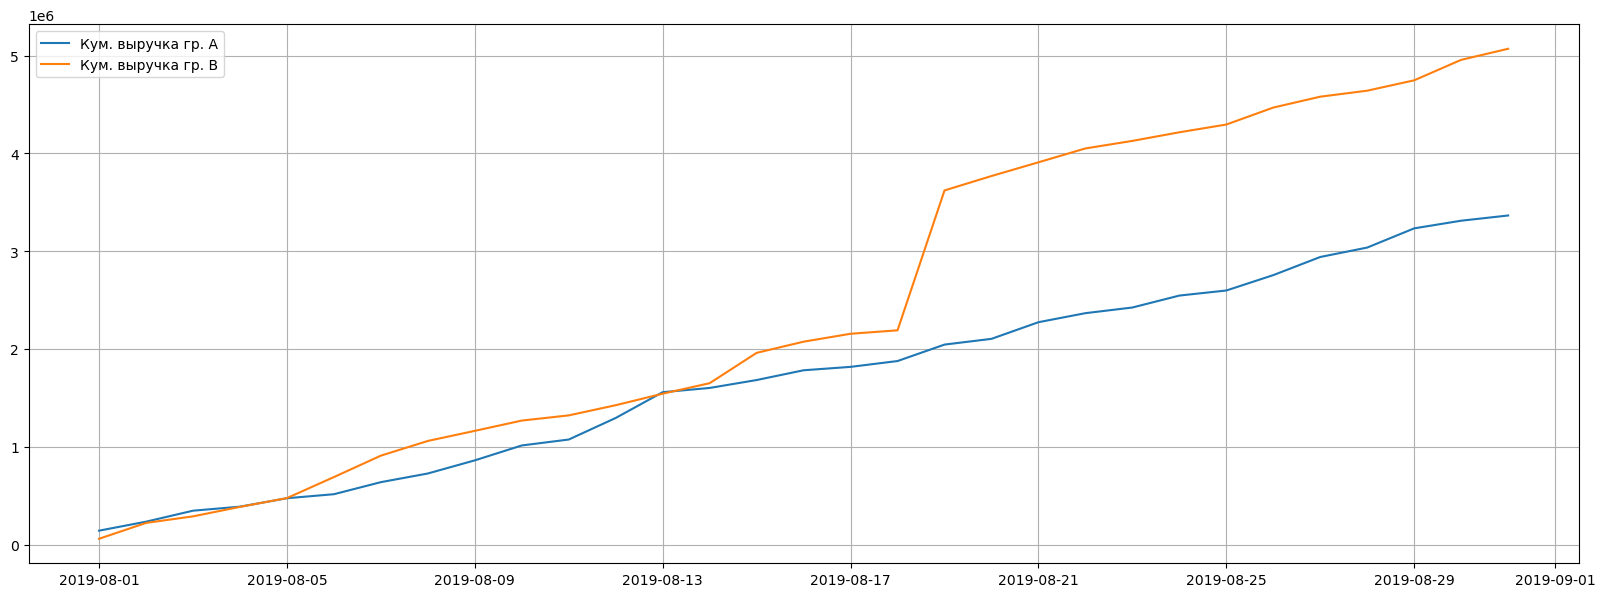

In [30]:
import matplotlib.pyplot as plt

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(20,7))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Кум. выручка гр. A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Кум. выручка гр. B')


plt.grid()
plt.legend()

**Вывод:**
Первые 5 дней августа динамика кумулятивной выручки двух групп примерно одинакова. Далее до 13 августа динамика показателя у гр В чуть лучше. 13 августа накопленная выручка по двум группам временно выравноивается. И после показатель группы В значительновырывается вперед. Необходимо отметить что примерно 19 августа по группе В произошол занчительный всплеск - возможно было большое количество заказов и значительно больше чем обычно, либо один разовый, но с большой выручкой.

Прверим это:

In [31]:
cumulativeRevenueB.query(' "2019-08-13" <= date <= "2019-08-21" ')

,date,revenue,orders
25,2019-08-13,1542928,249
27,2019-08-14,1650268,263
29,2019-08-15,1960427,289
31,2019-08-16,2074677,307
33,2019-08-17,2155542,320
35,2019-08-18,2190865,327
37,2019-08-19,3620785,348
39,2019-08-20,3768059,368
41,2019-08-21,3908406,380


Количество заказов не сильно выросло, при росте выручки.

In [32]:
orders.loc[(orders['date'] == "2019-08-19") & (orders['group'] == 'B')]

,transactionId,visitorId,date,revenue,group
315,1939633950,157579733,2019-08-19,2330,B
319,2414788465,2247745159,2019-08-19,1435,B
320,1652782757,2763027084,2019-08-19,1460,B
322,3154167297,2091902649,2019-08-19,250,B
363,2096847394,4251115836,2019-08-19,2500,B
367,1033377712,3860669668,2019-08-19,3990,B
368,3268879337,2536252163,2019-08-19,20026,B
423,4161654914,990904712,2019-08-19,11249,B
424,2609443403,2406916810,2019-08-19,470,B
425,590470918,1920142716,2019-08-19,1294500,B


19 августа был зарегистрирован заказ на сумму 1 295 тыс. Такой заказ был один, поэтому его можно считать выбросом и в дальнейшем учитывать это

### 	График кумулятивного среднего чека по группам. 

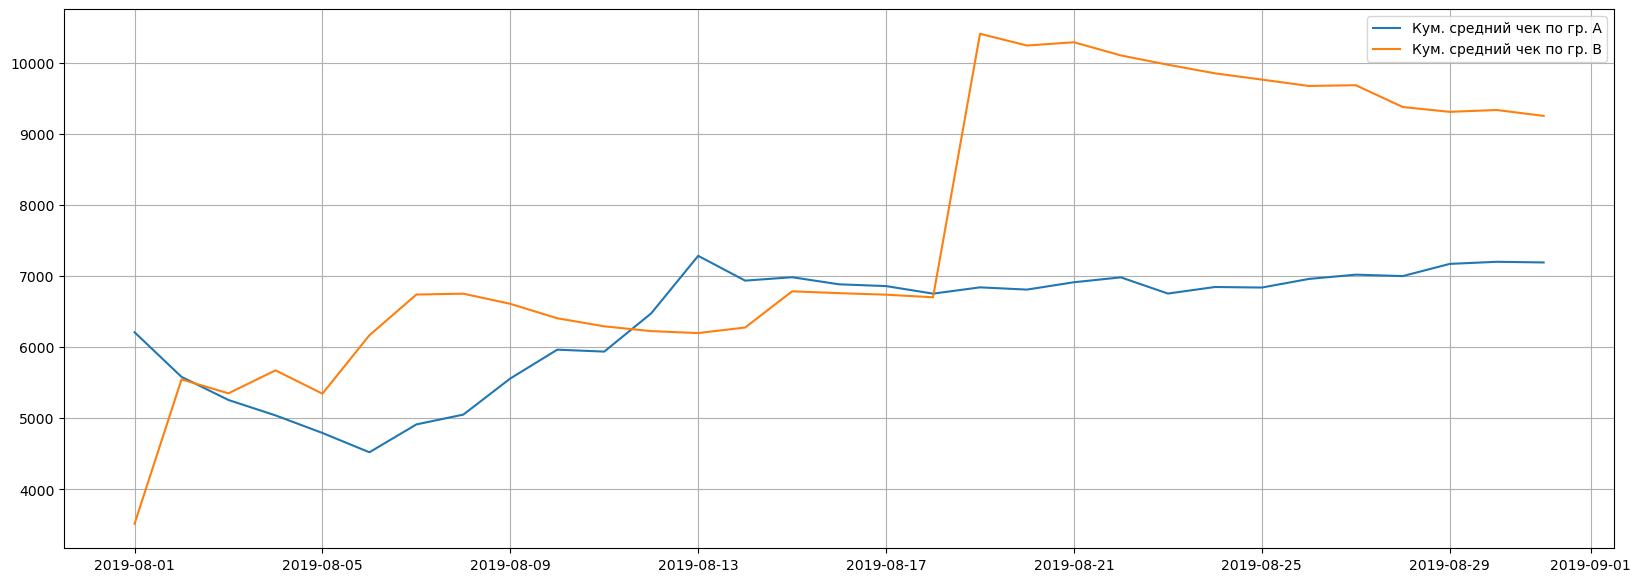

In [33]:
plt.figure(figsize=(20,7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='Кум. средний чек по гр. A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='Кум. средний чек по гр. B')

plt.grid()
plt.legend() 

**Вывод:**

График комулятивного среднего чека почти повторяет график кумулятивной выручки: "накопленный" средний чек по группе В выше показателя по гр А со 2 по 11 августа. Далее средний кумулятивный чек гр А на 4 дня становится выше. И опять,  с 15 августа показатель по гр В становится опять выше. Неоходимо также отметить всплеск 19 августа в связи разовым заказом на большую сумму

### 	График относительного изменения кумулятивного среднего чека группы B к группе A. 

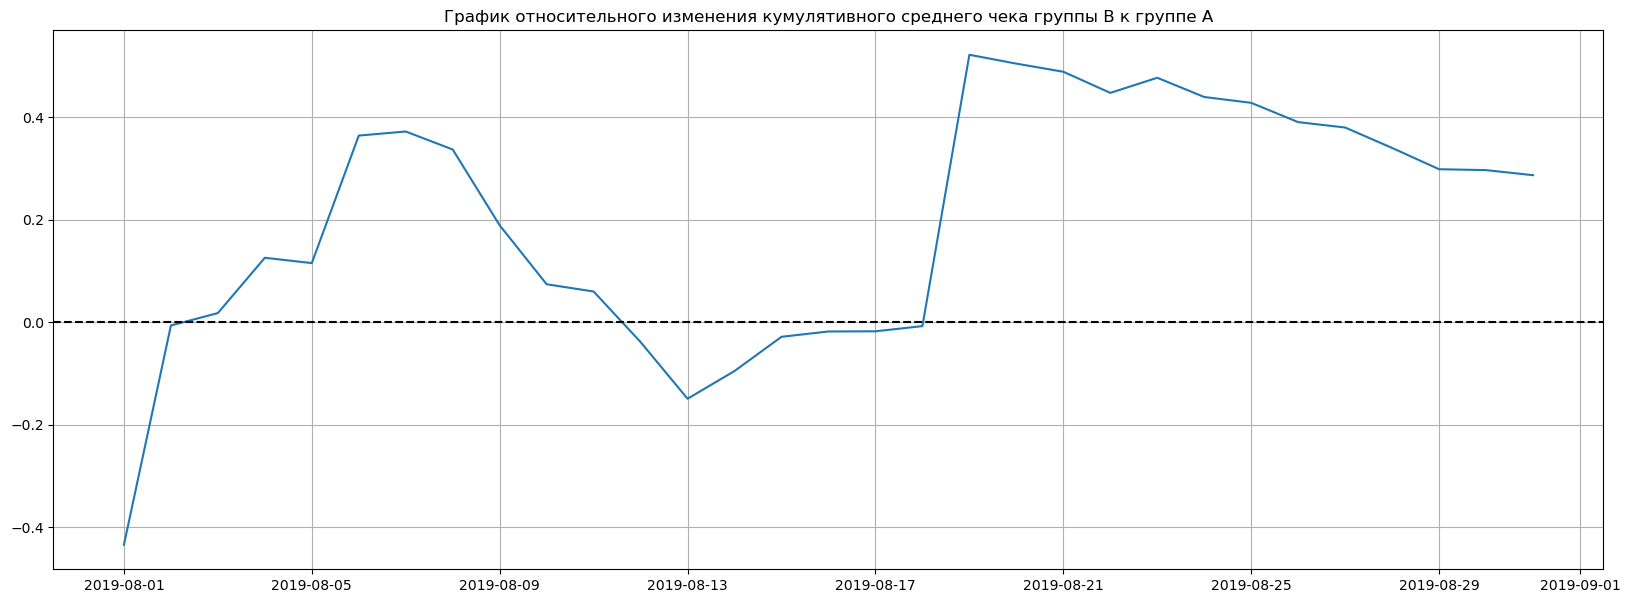

In [34]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(20,7))
plt.grid()
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

**Вывод:**
Кумулятивный средний чек по гр В растет до 17 августа с небольшими "провалами" 5 и 13 августа (в этот день вперед, на небольшое время, вырывается кумулятивный средний чек по гр А). Отметим всплеск показателя 19 августа из-за "большого" заказа по гр В. Далее кумулятивный средний чек по гр В постепенно падает, а по группе А - постепенно растет, но разница, примерно в 26% сохраняется.
Какие либо выводы на данном этапе по тесту пока делать нельзя



### 	График кумулятивной конверсии по группам. 

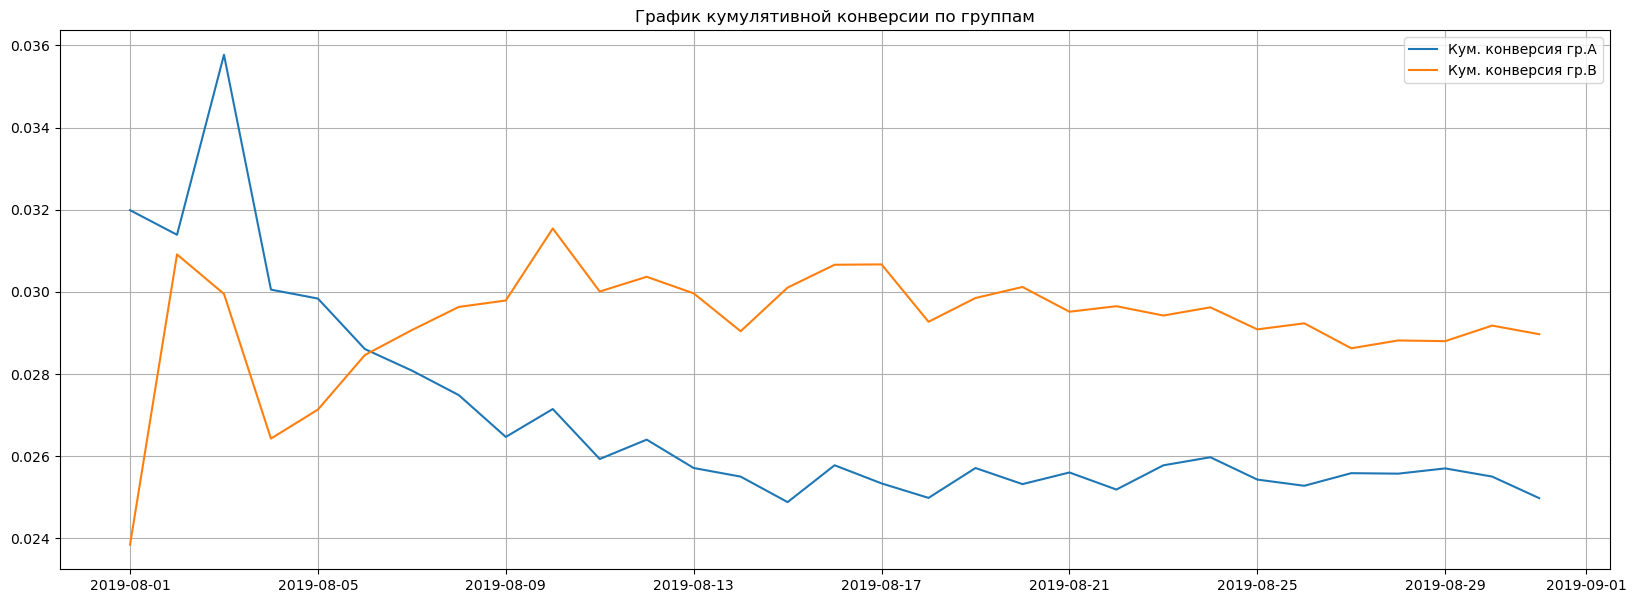

In [35]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.figure(figsize=(20,7))
plt.grid()
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='Кум. конверсия гр.A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='Кум. конверсия гр.B')
plt.title('График кумулятивной конверсии по группам')
plt.legend()


**Вывод:**

В начале месяца кумулятивная конверсия по обеим группам растет, причем по группе А с сильным опережением с пиком 0,037. Далее по обеим группам произошла корректировка в сторону снижения. По группе А тренд в сторону снижения продолжился до конца месяца и упал до уровня ниже 0,030.
Начиная с 4 августа кумулятивная конверсия по группе В поменяла тренд в сторону роста, 6 августа превысила конверсию группы А и 10 августа достигла максимального пика - более 0,036. Далее показатель поменял тренд на постепенное снижение до уровня 0,034 в конце месяца, с небольшим всплеском в период 14-18 августа.

### 	График относительного изменения кумулятивной конверсии группы B к группе A. 

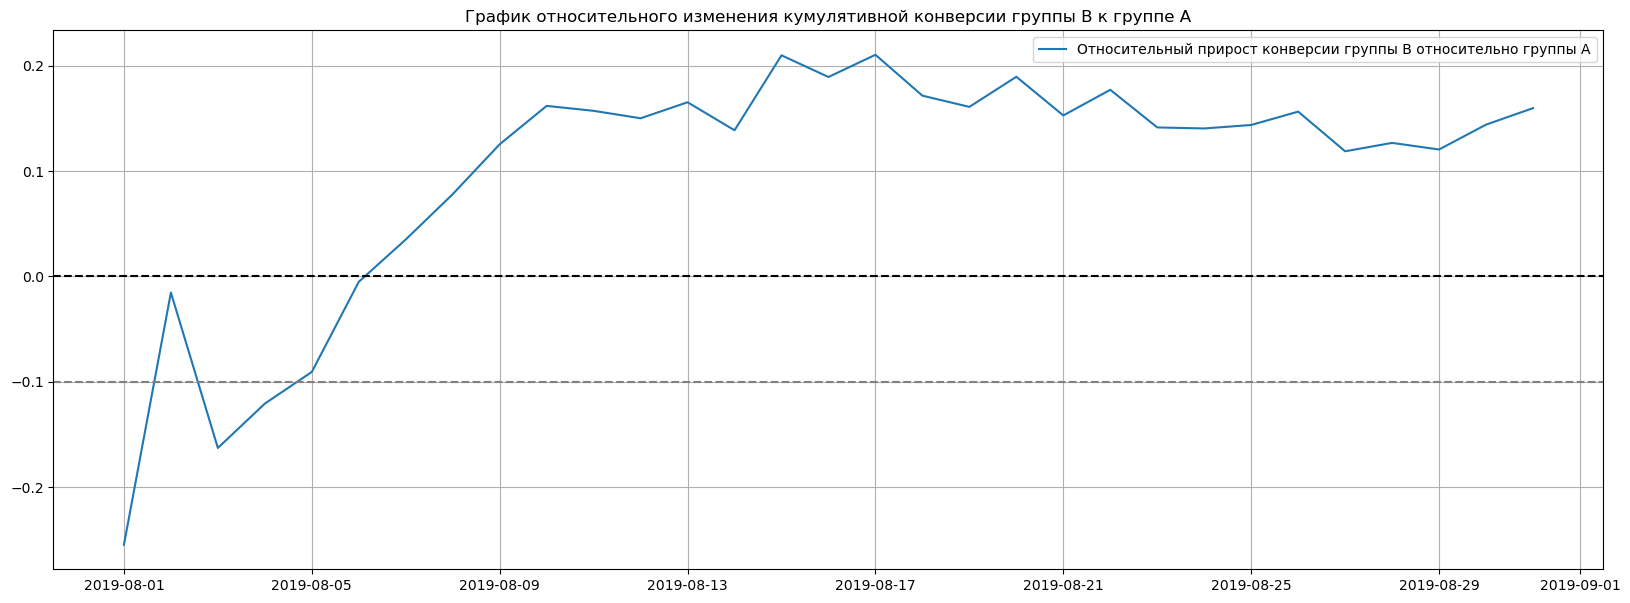

In [36]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(20,7))
plt.grid()
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')


**Вывод:**

График относительного изменения конверсии во многом повторяет график кумулятивной конверсии: в первые дни на относительное изменение влияет динамика кумулятивной коверсии по группе В - разница резко растет с -10% до 5%. Возможно в эти дни проводились маркетинговые мероприятия направленные на стимулирование продаж и именно по группе В. Далее, 3 августа произошла корректировка конверсии в сторону снижения, причем по обеим группам разница между группами А и В составила 7-8%%. Далее на показатель сильное вляение начинает оказывать тренд кумулятивной конверсии по группе В - разница изменилась с -8% до уровня 17-18% 10 августа. Далее кумулятивная конверсия по группе В начала постепенно снижаться и это повлияло на относительное изменение - 12-13%% в конце месяца. "Всплеск" наблюдаемый 14-18 августа также повторяет тренд кривой кумулятивной конверсии по группе В.

### 	Точечный график количества заказов по пользователям. 

In [37]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

         userId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


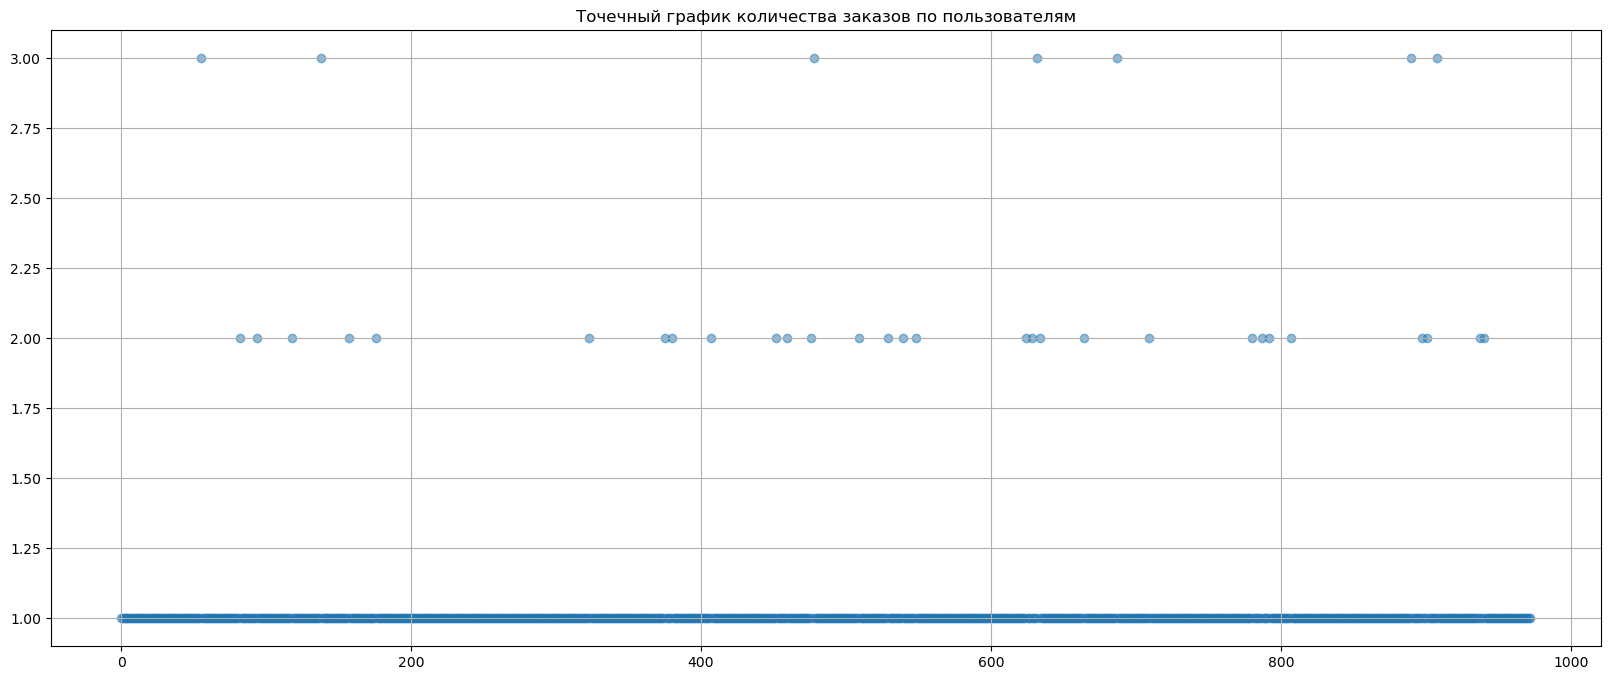

In [38]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(20,8))
plt.grid()
plt.title('Точечный график количества заказов по пользователям')
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.5) 

**Вывод:**

График показывает, что в течении месяца пользователи в основном делают по одному заказу. Тех кто делает 2 и более заказа очень и очень мало. Для того чтобы решить что это выбросы необходимо посчитать процентили 95 и 99.

### 	Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выбераем границу для определения аномальных пользователей.

Посчитаем сразу все процентили начиная с 95й:

In [39]:
print('95 и 99 перцентили по заказам :', np.percentile(ordersByUsers['orders'], [95, 96, 97, 98, 99]))

95 и 99 перцентили по заказам : [1. 1. 2. 2. 2.]


Из расчета видно, что 97% пользователей делают 1 или 2 заказа. Доля пользователей разместивших 3 и более заказов 3%. Это и будет выбросом.


### 	Точечный график стоимостей заказов. 

In [40]:
print(orders.sort_values(by='revenue', ascending=False).head(10))

      transactionId   visitorId       date  revenue group
425       590470918  1920142716 2019-08-19  1294500     B
1196     3936777065  2108080724 2019-08-15   202740     B
1136      666610489  1307669133 2019-08-13    92550     A
744      3668308183   888512513 2019-08-27    86620     B
743      3603576309  4133034833 2019-08-09    67990     A
1103     1348774318  1164614297 2019-08-12    66350     A
1099      316924019   148427295 2019-08-12    65710     A
949      1347999392   887908475 2019-08-21    60450     A
940      2420050534  4003628586 2019-08-08    58550     B
131      3163614039  2254586615 2019-08-22    53904     A


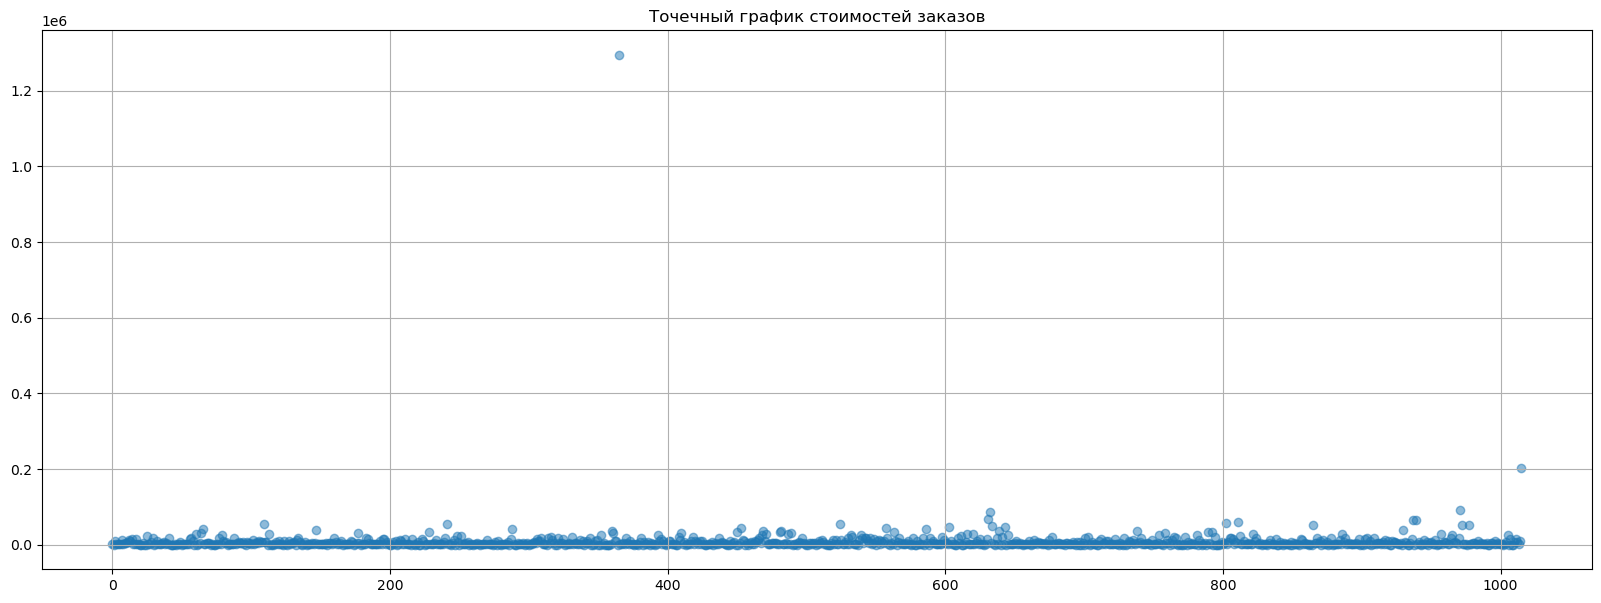

In [41]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(20,7))
plt.grid()
plt.title('Точечный график стоимостей заказов')
plt.scatter(x_values, orders['revenue'], alpha=0.5) 


На графике виден "аномальный" заказ на 1300 тыс. от 19 августа и еще один на чуть более 200 тыс. Очистим график от этих аномалий:

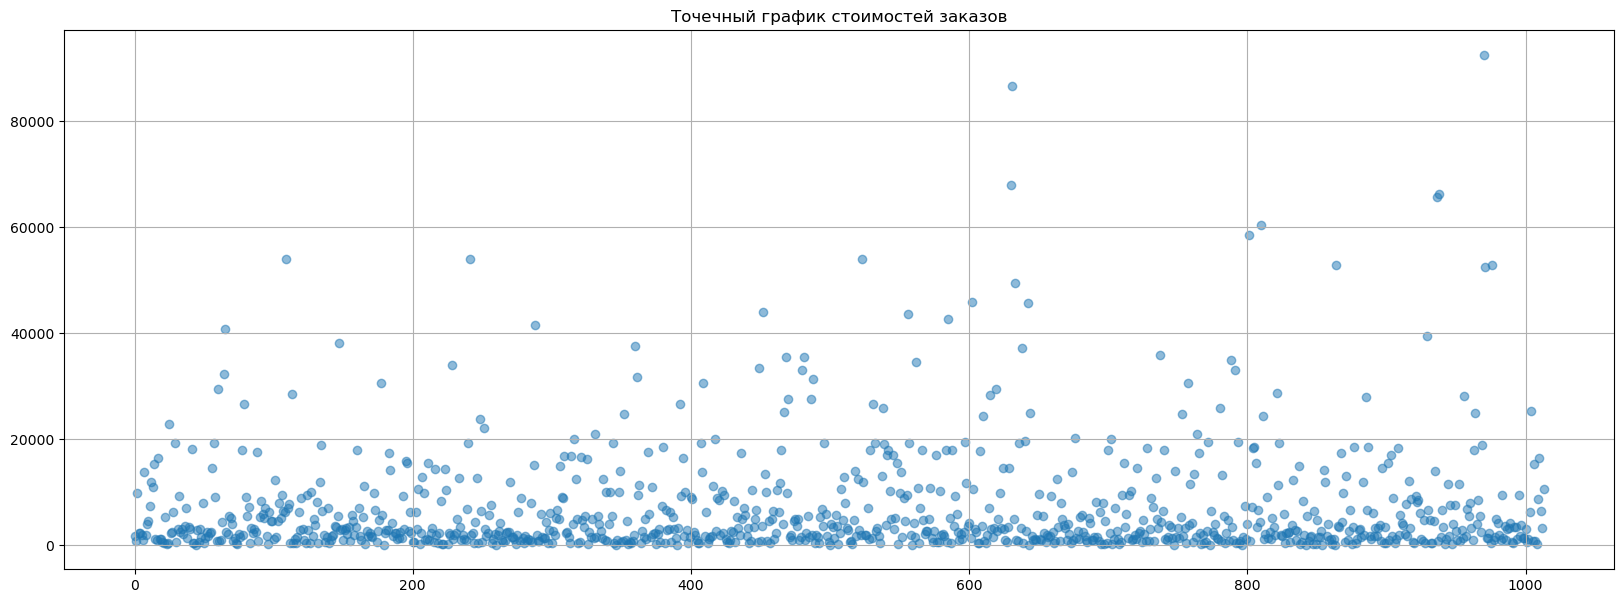

In [42]:
orders_adj = orders[orders['revenue'] <= 200000]['revenue']
x_values = pd.Series(range(0, len(orders_adj)))
plt.figure(figsize=(20,7))
plt.grid()
plt.title('Точечный график стоимостей заказов')
plt.scatter(x_values, orders_adj, alpha=0.5) 

На графике "без аномалий" хорошо видно, что основная масса заказов по стоимости находится в пределах от 0 до 20000 

### 	Посчитаем 95-й и 99-й перцентили стоимости заказов. Выбераем границу для определения аномальных заказов.

In [43]:
print('95 и 99 перцентили стоимости заказов:', np.percentile(orders['revenue'], [95, 99]))

95 и 99 перцентили стоимости заказов: [26785. 53904.]


**Вывод:**

Из расчета видно, что 99% заказов менее 53904. Определим ее в качестве границы для аномальных заказов.

### 	Статистическая значимость различий в конверсии между группами по «сырым» данным. 

In [44]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']



In [45]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [46]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

In [47]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

**Сформулируем гипотезы. Нулевая: статистически значимых различий в конверсии между группами нет. Альтернативная: статистически значимые различия в конверсии между группами есть.**

In [48]:
print("alpha =",0.05)

print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительный показатель B и A = {0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

alpha = 0.05
p-value = 0.011
Относительный показатель B и A = 0.160


**Вывод:**

"Сырые" данные говорят, что в конверсии между группами есть значимые различия: первое число p-value 0.011 меньше 0.05. Значит отвергаем нулевую гипотезу. При этом относительный выигрышь гр В над гр А составляет 16%

### 	Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 

**Сформулируем гипотезы. Нулевая: различий в среднем чеке заказа между группами нет. Альтернативная: различия в среднем чеке между группами есть.**

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [49]:
print("alpha =",0.05)
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный показатель B и A = {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

alpha = 0.05
p-value = 0.829
Относительный показатель B и A = 0.287


**Вывод:**

По «сырым» данным различий в среднем числе заказов групп A и B нет.
Первое число — p-value = 0.829 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке заказа между группами нет, не отвергаем. Однако относительный выигрыш группы B над группой А равен 28.7% — второе число в выводе.

### 	Статистическая значимость различий в конверсии между группами по «очищенным» данным.

Мы уже сделали вывод о том, что заказы в количестве более двух и стоимостью более 58233 считаем статистическими выбросами, поэтому проверим гипотезы, но уже с "чистыми" данными:

Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 58 233 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.
Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [50]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 53904]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64
16


Всего аномальных пользователей 16

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами по "чистым" данным.

In [51]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [52]:
print("alpha =",0.05)
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный показатель B и A = {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

alpha = 0.05
p-value = 0.007
Относительный показатель B и A = 0.189


**Вывод:**

"Чистые" данные не повлияли на ранее сделанное заключение: первое число p-value 0.007 меньше 0.05. Нулевую гипотезу об отсутствии статистически значимых отличий в конверсии между группами отвергаем. При этом конверсия гр В по прежнему выше конверсии гр А на 18,9%.

### 	Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

In [53]:
print("alpha =",0.05)
print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительный показатель 'B' и 'A' = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

alpha = 0.05
p-value = 0.788
Относительный показатель 'B' и 'A' = -0.032


**Вывод:**

По «чистым» данным различий в среднем числе заказов групп A и B нет.
Первое число — p-value = 0.788 значительно больше 0.05. Значит нулевую гипотезу о том, что статистически значимых различий в среднем чеке заказа между группами нет, не отвергаем. Необходимо отметить, что разница между средним чеком группы В и группы А незначительна - всего 3% в пользу гр А. Полагаю, что в данном случае мы видим влияние того единственного аномального заказа на сумму 1,3 млн 19 августа.

### 	Решение по результатам теста. 

На анализ А/В теста были предоставлены данные в дата фреймах orders и visitors. Данные предоставлены за период с 1 по 31 августа и сгруппированы по двум группам. У данных нет пропусков и дубликатов.
В целях проведения А/В теста были выдвинуты гипотезы: основные - статистически значимых различий в конверсии и среднем чеке заказа между группами нет, а также альтернативные гипотезы – статистически значимые различия в конверсии и среднем чеке заказа между группами есть
В рамках анализы были выполнены следующие шаги:
- построен график кумулятивной выручки по группам;
- график кумулятивного среднего чека по группам;
- график относительного изменения кумулятивного среднего чека одной группы к другой;
- график кумулятивной конверсии по группам;
- график относительного изменения кумулятивной конверсии одной группы к другой;
- для определения выбросов были рассчитаны перцентили;
- были посчитаны статистические значимости различий в конверсии и среднем чеке заказа по «сырым» и «очищенным» данным. В данном шаге использовался метод Манна-Уитни


**По результатм проведенного теста можно сделать следующие выводы:**

 - Есть статистически значимые различия в конверсии между группами А и В и это показали тесты как с "сырыми" данными, так и с "очищенными". Относительные выигрыш группы В на группой А составляет 18,9% по "очищенным" данным и 16% по "сырым".

 - Тесты по "сырым" и "очищенным" данным, также показали отсутствие статистически значимых отличий в среднем чеке между группами. При этом на результаты анализа на основе "сырых" данных влиял выброс в виде заказа на сумму 1,3 млн от 19 августа. В этом случае анализ показал что средний чек группы В на 28,7% выше среднего чека по группе А. После того как данные были очищены и данные выброс перестал оказывать влияние разница между средними чеками групп стала минимальной и составила 3%
 
 


**Исходя из полученных данных А/В тест можно признать успешным, прекратить его и зафиксировать победу группы В:** 

**- группа В значительно выигрывает по конверсии**

**- по сумме среднего чека группы примерно одинаковы** 